**Импорт необходимых библиотек, загрузка и приведение данных к удобному формату**

In [1]:
#!pip install joypy
import joypy as jp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from pmdarima.utils import tsdisplay
from statsmodels.tsa.seasonal import STL
from termcolor import colored
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import r2_score, mean_squared_error
from datetime import datetime, timedelta

#-------------Загрузим данные и перейдем к недельным интервалам:
dataset_=pd.read_csv('Search_statistics.csv',';',index_col=['date'],parse_dates=['date'],squeeze=True,dayfirst=True)
dataset_['searches'] = dataset_['searches'] * 1.0
dataset=dataset_[dataset_.host=='mobile_web']
del dataset['host']

#-------------Выравниваем аномалии, если есть. В 5 раз больше/меньше средних
avg=dataset.searches.mean()
dataset[dataset['searches']>5*avg] #тут ничего не найдено
dataset[dataset['searches']<avg*1/5] #тут отловили 1 неделю в окт2016

#-------------Заполняем текущую неделю флэтом средних из предыдущей и последующей недели
#смотрим средние по неделям
min1=min(dataset[dataset['searches']<avg*1/5].index) + timedelta(days=-7)
max1=min(dataset[dataset['searches']<avg*1/5].index) + timedelta(days=-1)
one=dataset[(dataset.index>=min1) & (dataset.index<=max1)].mean()
min2=max(dataset[dataset.searches < avg*1/5].index) + timedelta(days=1)
max2=max(dataset[dataset.searches < avg*1/5].index) + timedelta(days=7)
two=dataset[(dataset.index>=min2) & (dataset.index<=max2)].mean()
#вставляем их в целевую неделю
d=dataset[(dataset.index>=min1 + timedelta(days=7))&(dataset.index<=max1+ timedelta(days=7))]
d['searches']=((one+two)/2)[0]
dataset.loc[d.index, ['searches']] = np.nan
dataset[(dataset.index>=min1 + timedelta(days=7))&(dataset.index<=max1+ timedelta(days=7))]
dataset = dataset.combine_first(d)
dataset[(dataset.index>=min1 + timedelta(days=7))&(dataset.index<=max1+ timedelta(days=7))]
#-------------Пакуем в недели
w = dataset.searches.resample('w').sum()
w=w.drop(w.index[-1]) 
w
#-------------Делаем заготовку из пустых дат 2019 года для размещения прогнозных значений:
train=w.to_frame()
from pandas.tseries.offsets import DateOffset
add_dates = [train.index[-1] + DateOffset(weeks=x) for x in range(0,53) ]
test = pd.DataFrame(index=add_dates[1:],columns=train.columns)
test['searches']=0
full=pd.concat([train,test],axis=0)
#----------Добавляем полей для разных разрезов
dataset_['Year'] = dataset_.index.year
dataset_['Month'] = dataset_.index.month
dataset_['YearMon'] = dataset_.index.to_period('M')
dataset_['Day'] = dataset_.index.day
dataset_['WeekOfYear'] = dataset_.index.weekofyear 
dataset_['DayOfWeek'] = dataset_.index.dayofweek # 0-6 
dataset_['isWeekend'] = 1*(dataset_['DayOfWeek'] >4)
dataset_['type'] = 1
#----------Убираем 1 нулевое значение для WEB из Янв2016
d=min(dataset_[dataset_.host=='web'].index)
dataset_ = dataset_.drop(dataset_[(dataset_.host=='web') & (dataset_.index==d)].index)
#----------Делаем сводную таблицу
dataset_.dtypes
ds_gr=dataset_.groupby(['host','date'])['searches'].sum()
ds_gr=ds_gr.unstack(0)
ds_gr['Year'] = ds_gr.index.year
ds_gr['Month'] = ds_gr.index.month
ds_gr = ds_gr.reset_index()
ds_gr = ds_gr.fillna(0)
dataset_

,host,searches,Year,Month,YearMon,Day,WeekOfYear,DayOfWeek,isWeekend,type
date,,,,,,,,,,
2016-01-01,iOS,23833.0,2016,1,2016-01,1,53,4,0,1
2016-01-01,mobile_web,8708.0,2016,1,2016-01,1,53,4,0,1
2016-01-02,Android,1.0,2016,1,2016-01,2,53,5,1,1
2016-01-02,iOS,25793.0,2016,1,2016-01,2,53,5,1,1
2016-01-02,mobile_web,9012.0,2016,1,2016-01,2,53,5,1,1
...,...,...,...,...,...,...,...,...,...,...
2018-12-30,web,74387.0,2018,12,2018-12,30,52,6,1,1
2018-12-31,Android,18125.0,2018,12,2018-12,31,1,0,0,1
2018-12-31,iOS,36215.0,2018,12,2018-12,31,1,0,0,1


**Анализ исходных данных**

---------------------------  2018  ---------------------------


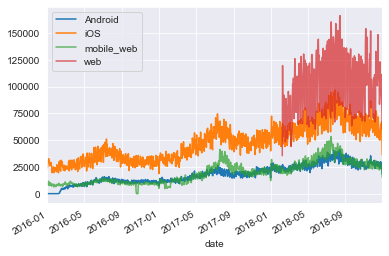

In [2]:
print(colored('---------------------------  2018  ---------------------------', 'green', attrs=['bold']))
dataset_[(dataset_.host=='Android')]['searches'].plot()
dataset_[(dataset_.host=='iOS')]['searches'].plot()
dataset_[(dataset_.host=='mobile_web')]['searches'].plot(alpha=0.7)
dataset_[(dataset_.host=='web') ]['searches'].plot(alpha=0.7)
plt.legend(['Android','iOS','mobile_web','web'])
plt.show()


---------------------------  Сравнение типов распределений, хвостов и средних значений по годам  ---------------------------


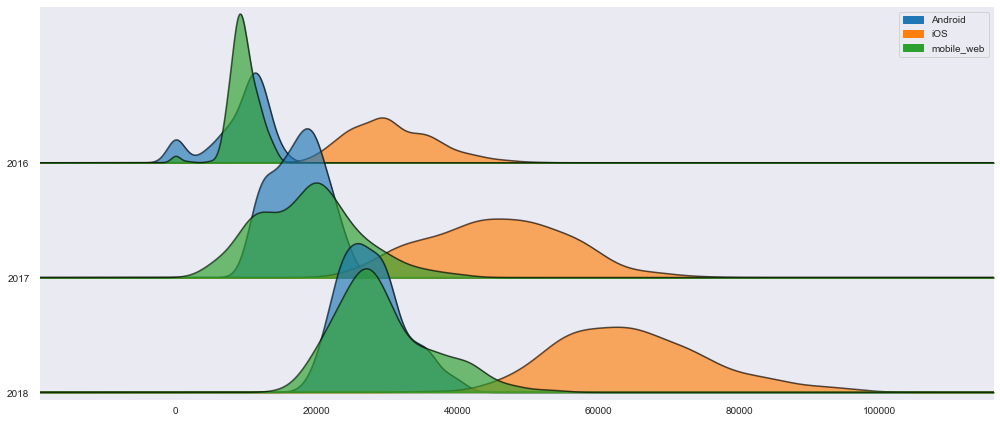

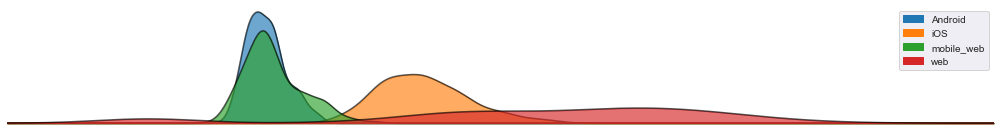

In [3]:
print(colored('---------------------------  Сравнение типов распределений, хвостов и средних значений по годам  ---------------------------', 'green', attrs=['bold']))
fig, axes = jp.joyplot(ds_gr, column=['Android','iOS','mobile_web'], by="Year", ylim='own', figsize=(14,6),alpha=0.65, legend=True)
fig, axes = jp.joyplot(ds_gr[ds_gr.Year==2018], column=['Android','iOS','mobile_web','web',], by="Year", ylim='own', figsize=(14,2),alpha=0.65, legend=True)


---------------------------  Средний объём запросов по дням недели  ---------------------------


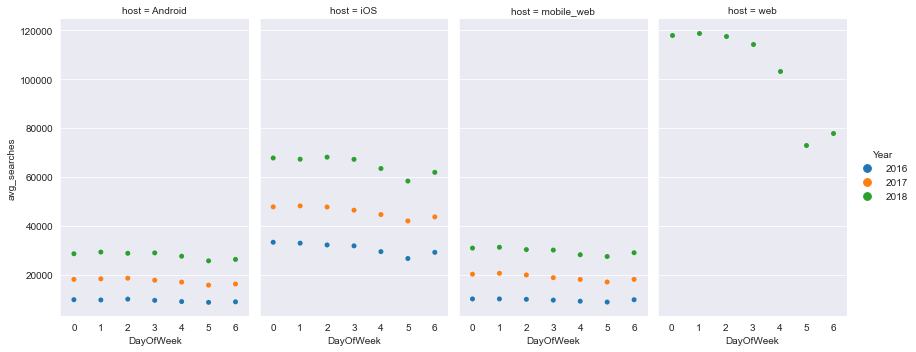

In [4]:
print(colored('---------------------------  Средний объём запросов по дням недели  ---------------------------', 'green', attrs=['bold']))
dataset_.dtypes
ds_weekday=dataset_.groupby(['type','host','Year','DayOfWeek'])['searches'].mean()
ds_weekday=ds_weekday.unstack(0)
ds_weekday = ds_weekday.reset_index()
#ds_weekday = ds_weekday.fillna(0)
ds_weekday.rename(columns={1:'avg_searches'}, inplace=True)

sns.catplot(x="DayOfWeek", y="avg_searches", hue="Year",
            col="host", aspect=.6,
            kind="swarm", data=ds_weekday);


In [5]:
ds_dw=dataset_.groupby(['host','Year','DayOfWeek',])['searches'].mean()
ds_dw=ds_dw.unstack(0)
ds_dw = ds_dw.reset_index()

'''
#Проверим нулевые значения. Их 2, но 1 в Андроиде оставим, а в вебе оно явно лишнее.
dataset_ = dataset_[~((dataset_['searches'] ==0) & (dataset_['host'] == 'web'))]
sns.factorplot(data = dataset_[dataset_['host'] != 'web'], x ="Month", y = "searches", 
               col = 'host', 
               hue = 'isWeekend',
               row = "Year"
             );
'''
print("")


Запомнил фразу из интервью одного ТОПа travel-индустрии, что у обывателей cложилось превратное представление о том, что авиаперелеты процентов на 70-80% состоят из поездок в отпуск, хотя их не более 40%. Очень много командировок и обычных поездок.

Максимум посковых запросов:
Ожидаемо самый "урожайный" месяц - это июль. Много людей ищет билет в моменте здесь и сейчас или на август и сентябрь.

Минимум посковых запросов:
Февраль - первый месяц когда все только вернулись с новогодних праздников и в отпуск пока никто не собирается.

Также интересно отметить, что после сезона летних отпусков в 2016 и 2018 наблюдается планомерное снижение к концу года. Но в 2017 сентябрь-октябрь стали отправной точкой роста поисковых запросов в октябре-декабре. Возможно увеличилась доля ранних бронирований или чуть больше людей решило отпраздновать Новый 2018 год в другом месте.

---------------------------  TOTAL  ---------------------------


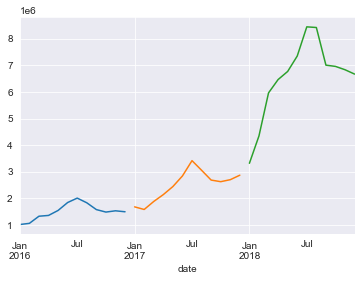


3я четверть 2018 вообще проседает по всем хостам, кроме WEB. Такое ощущение, что ходившие в то время слухи о надвигающейся рецессии оказали негативное влияние. Кстати, я ожидал, что появление нового хоста WEB заберет на себя долю ото всех других хостов, но этого не произошло. Либо WEB жил и раньше, просто мониториться начал с 2018.

Владельцы айфонов ранее считались более состоятельными, а Android более практичными. Возможно, это могло наложить отпечаток на временной ряд iOS, но сопоставление с другими хостами показывает, что iOS свойственны общие тенденции.


---------------------------  Android  ---------------------------


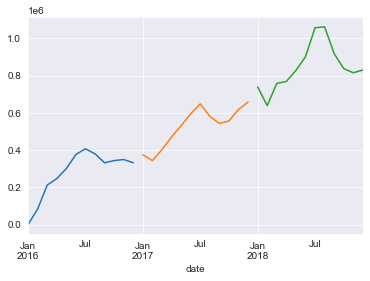


---------------------------  iOS  ---------------------------


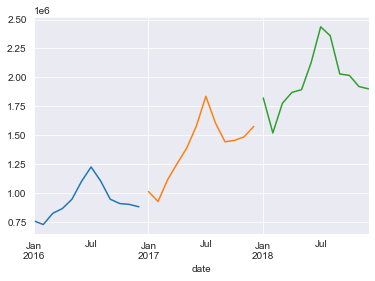


---------------------------  mobile_web  ---------------------------


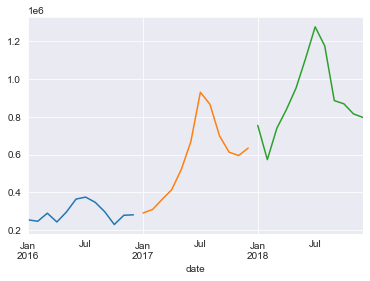


---------------------------  web  ---------------------------


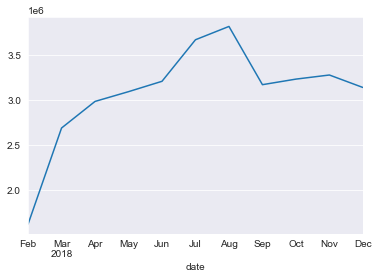


WEB имеет довольно сильную помесячную корреляцию с тремя другими хостами. Моделировать WEB в 2016 и 2017 будем по объёмам всех трёх остальных
Помесячная корреляция WEB и Android в 2018 =  0.8838448996069526
Помесячная корреляция WEB и iOS в 2018 =  0.8995468486159125
Помесячная корреляция WEB и mobile_web в 2018 =  0.8285602510439635


In [6]:

total = dataset_.searches.resample('m').sum()
total

dataset=dataset_[dataset_.host=='Android']
del dataset['host']
m = dataset.searches.resample('m').sum()

dataset=dataset_[dataset_.host=='iOS']
del dataset['host']
m2 = dataset.searches.resample('m').sum()

dataset=dataset_[dataset_.host=='mobile_web']
del dataset['host']
m3 = dataset.searches.resample('m').sum()

dataset=dataset_[dataset_.host=='web']
del dataset['host']
m4 = dataset.searches.resample('m').sum()


print(chr(13))
print('Запомнил фразу из интервью одного ТОПа travel-индустрии, что у обывателей cложилось превратное представление о том, что авиаперелеты процентов на 70-80% состоят из поездок в отпуск, хотя их не более 40%. Очень много командировок и обычных поездок.')
print(chr(13))

print('Максимум посковых запросов:')
print('Ожидаемо самый "урожайный" месяц - это июль. Много людей ищет билет в моменте здесь и сейчас или на август и сентябрь.')
print(chr(13))
print('Минимум посковых запросов:')
print('Февраль - первый месяц когда все только вернулись с новогодних праздников и в отпуск пока никто не собирается.')
print(chr(13))
print('Также интересно отметить, что после сезона летних отпусков в 2016 и 2018 наблюдается планомерное снижение к концу года. Но в 2017 сентябрь-октябрь стали отправной точкой роста поисковых запросов в октябре-декабре. Возможно увеличилась доля ранних бронирований или чуть больше людей решило отпраздновать Новый 2018 год в другом месте.')
print(chr(13))

print(colored('---------------------------  TOTAL  ---------------------------', 'green', attrs=['bold']))
total.head(12).plot()
total.iloc[12:24].plot()
total.tail(12).plot()
plt.show()

print(chr(13))
print('3я четверть 2018 вообще проседает по всем хостам, кроме WEB. Такое ощущение, что ходившие в то время слухи о надвигающейся рецессии оказали негативное влияние. Кстати, я ожидал, что появление нового хоста WEB заберет на себя долю ото всех других хостов, но этого не произошло. Либо WEB жил и раньше, просто мониториться начал с 2018.')
print(chr(13))
print('Владельцы айфонов ранее считались более состоятельными, а Android более практичными. Возможно, это могло наложить отпечаток на временной ряд iOS, но сопоставление с другими хостами показывает, что iOS свойственны общие тенденции.')
print(chr(13))

print(chr(13))
print(colored('---------------------------  Android  ---------------------------', 'green', attrs=['bold']))
m.head(12).plot()
m.iloc[12:24].plot()
m.tail(12).plot()
plt.show()

print(chr(13))
print(colored('---------------------------  iOS  ---------------------------', 'green', attrs=['bold']))
m2.head(12).plot()
m2.iloc[12:24].plot()
m2.tail(12).plot()
plt.show()

print(chr(13))
print(colored('---------------------------  mobile_web  ---------------------------', 'green', attrs=['bold']))
m3.head(12).plot()
m3.iloc[12:24].plot()
m3.tail(12).plot()
plt.show()

print(chr(13))
print(colored('---------------------------  web  ---------------------------', 'green', attrs=['bold']))
m4.tail(12).plot()
plt.show()


#-------------------------------
dataset=dataset_[(dataset_.host=='Android') & (dataset_.Year==2018) ]
del dataset['host']
m1 = dataset.searches.resample('m').sum()
m1=m1[1:].to_frame()

dataset=dataset_[(dataset_.host=='iOS') & (dataset_.Year==2018) ]
del dataset['host']
m2 = dataset.searches.resample('m').sum()
m2=m2[1:].to_frame()

dataset=dataset_[(dataset_.host=='mobile_web') & (dataset_.Year==2018) ]
del dataset['host']
m3 = dataset.searches.resample('m').sum()
m3=m3[1:].to_frame()

dataset=dataset_[(dataset_.host=='web') & (dataset_.Year==2018) ]
del dataset['host']
m4 = dataset.searches.resample('m').sum()
m4=m4.to_frame()

#считаем корреляции с WEB
print(chr(13))
print(colored('WEB имеет довольно сильную помесячную корреляцию с тремя другими хостами. Моделировать WEB в 2016 и 2017 будем по объёмам всех трёх остальных', 'green', attrs=['bold']))
print('Помесячная корреляция WEB и Android в 2018 = ', np.corrcoef(m1['searches'].to_numpy(), m4['searches'].to_numpy())[0,1])
print('Помесячная корреляция WEB и iOS в 2018 = ', np.corrcoef(m2['searches'].to_numpy(), m4['searches'].to_numpy())[0,1])
print('Помесячная корреляция WEB и mobile_web в 2018 = ', np.corrcoef(m3['searches'].to_numpy(), m4['searches'].to_numpy())[0,1])

**Анализ компонентов временного ряда на примере хоста Android**

Лучшую модель тиражируем на остальных. Mobile_web и iOS тоже смотрел. Логика та же. 

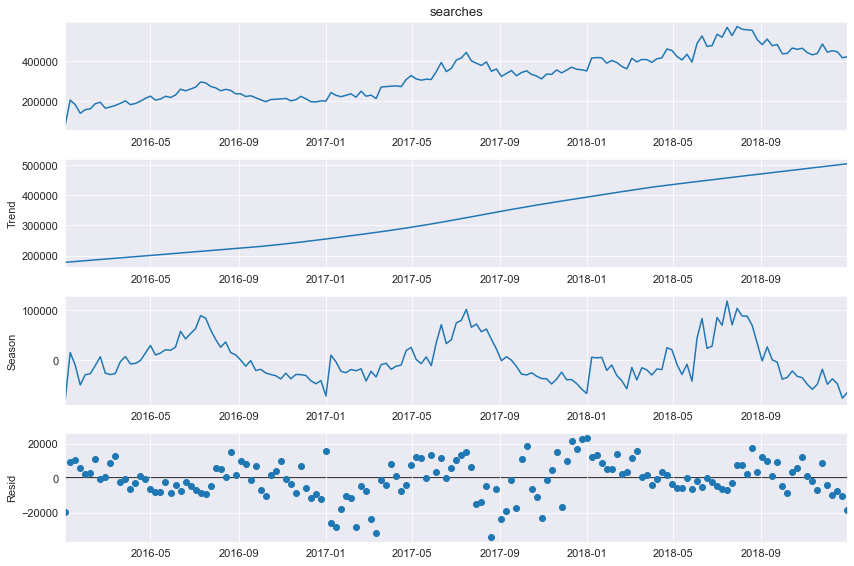

In [7]:
dataset=dataset_[dataset_.host=='iOS']
del dataset['host']
w = dataset.searches.resample('w').sum()
w=w.drop(w.index[-1]) 
w
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=11)

stl = STL(w, seasonal=11)
res = stl.fit()
fig = res.plot()

**Модель1. С использованием пакета Facebook PROPHET**

Основной источник информации по теории:
http://www.machinelearning.ru/wiki/images/d/d0/Psad_ts_arima.pdf

In [8]:
'''Модель1. Метод экспоненциального сглаживания с трендом и сезонностью Хольта - Винтерса

model = ExponentialSmoothing(train, 
                             trend='add', 
                             damped=False, 
                             seasonal='add', 
                             seasonal_periods=52).fit()
f_holt_train_pred = model.predict(start=train.index[0], end=train.index[-1])
f_holt_train_pred=f_holt_train_pred.to_frame()
f_holt_train_pred.columns=['s_holt']
for_rmse=train.join(f_holt_train_pred)
f_holt = model.predict(start=test.index[0], end=test.index[-1])

plt.figure(figsize=(22, 10))
plt.plot(train.index, train, label='Реальные данные')
plt.plot(f_holt.index, f_holt, label='Прогноз Holt-Winters', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()


f_holt_iOS=f_holt.to_frame()
f_holt_iOS.columns=['y']
f_holt_iOS.index.names = ['ds']
'''
print('')

In [9]:
from fbprophet import Prophet
dataset_=pd.read_csv('Search_statistics.csv',';',index_col=['date'],parse_dates=['date'],squeeze=True,dayfirst=True)
dataset_['searches'] = dataset_['searches'] * 1.0
dataset=dataset_[dataset_.host=='iOS']
del dataset['host']

dataset.index.names = ['ds']
dataset.columns =['y']
dataset = dataset.reset_index()
m = Prophet()
m.fit(dataset)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = m.make_future_dataframe(periods=365)
future.tail()

# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

f_proph_res_nweb = forecast[['ds', 'yhat']].tail(365)
f_proph_res_nweb.columns=['ds','y']
f_proph_res_nweb.index=f_proph_res_nweb['ds']
del f_proph_res_nweb['ds']


Отдельно зафиксируем, как модель отработала на имеющихся фактических значениях, чтобы в будущем рассчитать RMSE

In [11]:
f_proph_train_pred= forecast[['ds', 'yhat']].head(365*3)
f_proph_train_pred.columns=['date','s_prophet']
f_proph_train_pred.index=f_proph_train_pred['date']
del f_proph_train_pred['date']


f_proph_train_pred = f_proph_train_pred.s_prophet.resample('w').sum()
f_proph_train_pred=f_proph_train_pred.to_frame()
for_rmse=train.join(f_proph_train_pred)

#for_rmse=for_rmse.join(f_proph_train_pred, how='inner', lsuffix='_left', rsuffix='_right')


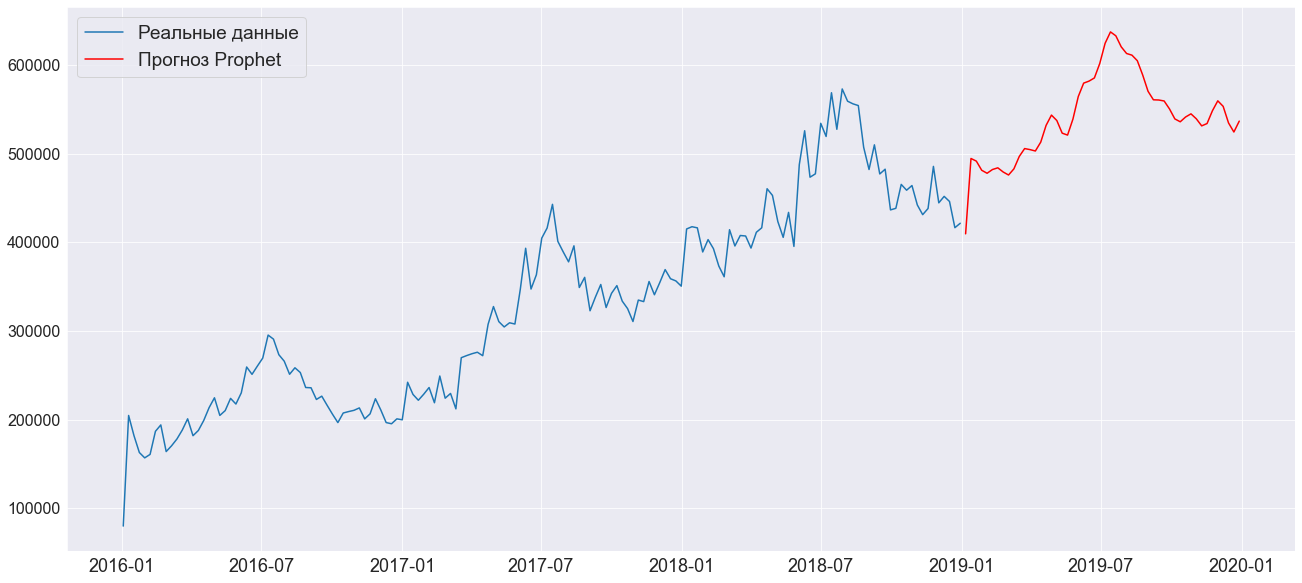

In [12]:
#pd.plotting.register_matplotlib_converters()
f_proph=forecast[['ds','yhat']].tail(365)
f_proph.columns=['ds','y']
f_proph.index=f_proph['ds']
del f_proph['ds']

dataset.index=dataset['ds']
del dataset['ds']

dataset = dataset.y.resample('w').sum()
dataset=dataset.to_frame()
f_proph = f_proph.y.resample('w').sum()
dataset=dataset.drop(dataset.index[-1]) 
f_proph=f_proph.drop(f_proph.index[-1]) 

'''
merged=pd.concat([dataset, f], axis=0)
merged.index=merged.ds
del merged['ds']

w_prophet = merged.y.resample('w').sum()
w_prophet=w_prophet.drop(w_prophet.index[-1]) 
w_prophet.plot()
plt.show()
'''

plt.figure(figsize=(22, 10))
plt.plot(dataset.index, dataset, label='Реальные данные')
plt.plot(f_proph.index, f_proph, label='Прогноз Prophet', color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

#f_proph=f_proph.to_frame()

**Модель2. Сезонная ARIMA (методология Бокса — Дженкинса)**

В нашем графике присутствует тренд, что уже говорит о том, что он нестаионарен.
Тест Дики-Фуллера дополнительно подтверждает это. Попробуем применить ещё одну модель ARIMA является расширением моделей ARMA для нестационарных временных рядов, которые можно сделать стационарными взятием разностей некоторого порядка от исходного временного ряда.

In [13]:
w=w.to_frame()

from pmdarima.arima import auto_arima
decomposition = auto_arima(w.searches, start_p=1, start_q=1, max_p=3, max_q=3, m=52,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',  suppress_warnings=True, stepwise=True)


Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,52) [intercept=True]; AIC=2395.116, BIC=2408.338, Time=9.454 seconds
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=True]; AIC=2424.509, BIC=2429.797, Time=0.436 seconds
Fit ARIMA(1,1,0)x(1,1,0,52) [intercept=True]; AIC=2396.245, BIC=2406.823, Time=4.603 seconds
Fit ARIMA(0,1,1)x(0,1,1,52) [intercept=True]; AIC=2393.284, BIC=2403.862, Time=7.652 seconds
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=False]; AIC=2423.505, BIC=2426.149, Time=0.752 seconds
Fit ARIMA(0,1,1)x(0,1,0,52) [intercept=True]; AIC=2419.275, BIC=2427.209, Time=0.719 seconds
Fit ARIMA(0,1,1)x(1,1,1,52) [intercept=True]; AIC=2394.170, BIC=2407.392, Time=14.836 seconds
Fit ARIMA(0,1,1)x(0,1,2,52) [intercept=True]; AIC=2394.103, BIC=2407.325, Time=21.229 seconds
Fit ARIMA(0,1,1)x(1,1,0,52) [intercept=True]; AIC=2393.367, BIC=2403.944, Time=3.998 seconds
Fit ARIMA(0,1,1)x(1,1,2,52) [intercept=True]; AIC=2396.097, BIC=2411.964, Time=44.662 seconds
Fit ARIMA(0,1,0)x(0,1,1

Оптимальный набор параметров (p,d,q)(P,D,Q) находится в строке со значением AIC, равным

In [14]:
'''
Чтобы сконфигурировать сезонную ARIMA нужно выбрать лучший набор гиперпараметров (p,d,q) для трендовых (P,D,Q) и сезонных компонент ряда.

p: порядок авторегрессии по трендовой компоненте
d: какого порядка берём трендовую разность
q: порядок скользящей средней по трендовой компоненте

P: порядок авторегрессии по сезонной компоненте
D: какого порядка берём сезонную разность
Q: порядок скользящей средней по сезонной компоненте
m: количество элементов в одном сезоне (52 недели в нашем случае)
SARIMA выполняет нейтрализацию сезонного эффекта вычитая ряд со сдвигом, указанным в m
'''
print('')
decomposition.aic()

2393.2841289271555

In [15]:
#Fit ARIMA(0,1,1)x(1,1,0,52) [intercept=True]; AIC=2393.367, BIC=2403.944, Time=4.670 seconds
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(w.searches, exog=None, #без экзогенной переменной SARIMAX становится SARIMA
                                order=(0,1,1),
                                seasonal_order=(1,1,0,52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

decomposition = mod.fit()
print(decomposition.summary())


                                      SARIMAX Results                                      
Dep. Variable:                            searches   No. Observations:                  157
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -599.249
Date:                             Mon, 27 Jul 2020   AIC                           1204.498
Time:                                     12:59:51   BIC                           1210.352
Sample:                                 01-03-2016   HQIC                          1206.742
                                      - 12-30-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5312      0.115     -4.626      0.000      -0.756      -0.306
ar.S.L52      -0.4390      

Команда plot_diagnotics() позволяет оценить остатки в модели. Можно увидеть, что их распредление близко к гауссовскому (N(0,1) - нормальное с мат.ожиданием=0 и дисперсией=1). Также остатки не коррелируют друг с другом (поскольку ни один из спайков (лагов) на правом нижнем графике не значим (не выходит из затенённой области за границы доверительных интервалов). Когда нет возможности визуально убедиться в нормальности остатков можно использовать тест Льюнга-Бокса. Из графика квантилей Q-Q также видно, что остатки концентрируются вблизи прямой линии, отображающей плотность вероятности нормального закона, следовательно, гипотезу о нормальности остатков можно принять. 


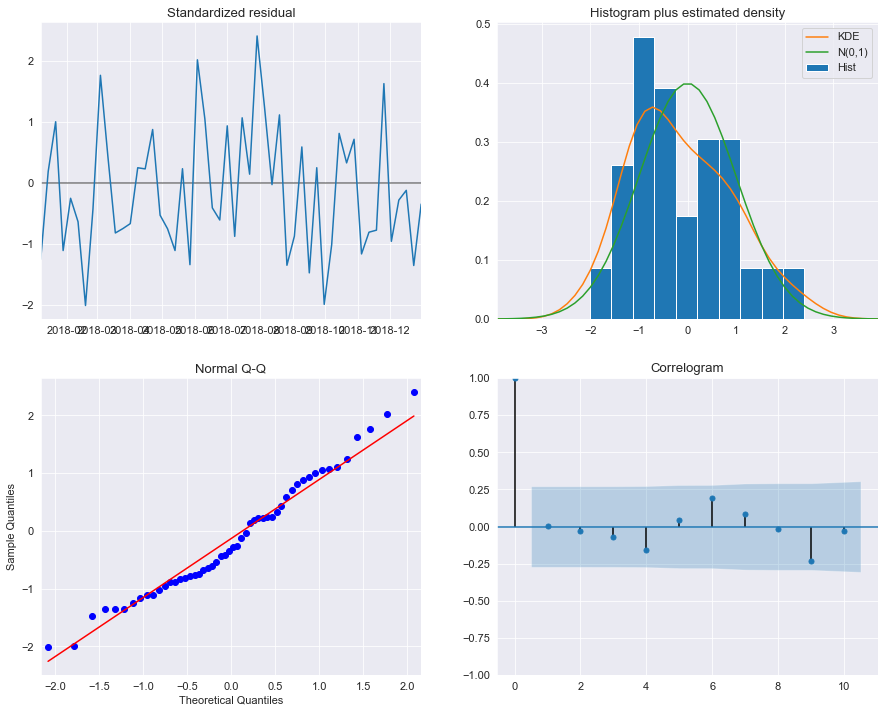

In [16]:
print('Команда plot_diagnotics() позволяет оценить остатки в модели. Можно увидеть, что их распредление близко к гауссовскому (N(0,1) - нормальное с мат.ожиданием=0 и дисперсией=1). Также остатки не коррелируют друг с другом (поскольку ни один из спайков (лагов) на правом нижнем графике не значим (не выходит из затенённой области за границы доверительных интервалов). Когда нет возможности визуально убедиться в нормальности остатков можно использовать тест Льюнга-Бокса. Из графика квантилей Q-Q также видно, что остатки концентрируются вблизи прямой линии, отображающей плотность вероятности нормального закона, следовательно, гипотезу о нормальности остатков можно принять. ')


decomposition.plot_diagnostics(figsize=(15, 12))
plt.show()


In [17]:
pred_uc = decomposition.get_forecast(steps=52)
pred_ci = pred_uc.conf_int()


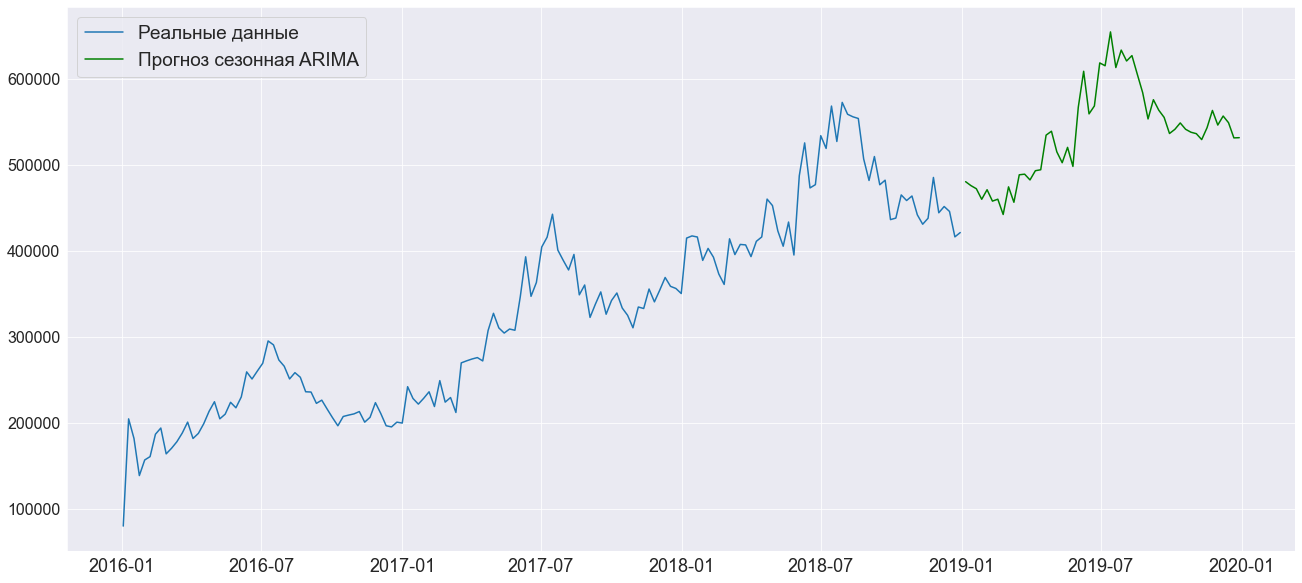

In [18]:
f_arima=pred_uc.predicted_mean.to_frame()
f_arima.columns=['y']
f_arima.index.names = ['ds']
f_arima

plt.figure(figsize=(22, 10))
plt.plot(w.index, w, label='Реальные данные')
plt.plot(f_arima.index, f_arima, label='Прогноз сезонная ARIMA', color='g')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

Отдельно зафиксируем, как модель отработала на имеющихся фактических значениях, чтобы в будущем рассчитать RMSE

In [19]:
f_sarima_train_pred= decomposition.predict(start=train.index[0], end=train.index[-1])
f_sarima_train_pred=f_sarima_train_pred.to_frame()
f_sarima_train_pred.columns=['s_sarima']
f_sarima_train_pred = f_sarima_train_pred.s_sarima.resample('w').sum()
f_sarima_train_pred=f_sarima_train_pred.to_frame()
for_rmse=for_rmse.join(f_sarima_train_pred, how='inner', lsuffix='_left', rsuffix='_right')
for_rmse

,searches,s_prophet,s_sarima
date,,,
2016-01-03,28530.0,64384.443586,0.000000
2016-01-10,66684.0,184056.896910,79807.000000
2016-01-17,58941.0,188223.035401,138563.637666
2016-01-24,55863.0,178119.333754,158958.750608
2016-01-31,51206.0,169342.578469,149363.488916
...,...,...,...
2018-12-02,190589.0,471252.370033,467351.514411
2018-12-09,189806.0,461778.025516,458594.835498
2018-12-16,180790.0,442908.074820,449037.318083


**Соберём все прогнозы воедино и посчитаем RMSE (среднеквадратичные ошибки предсказаний и наблюдений), чтобы выбрать лучшую модель, которую тиражируем на все хосты**

RMSE модели 1 =  198821.73757641995
RMSE модели 2 =  199154.08237982183


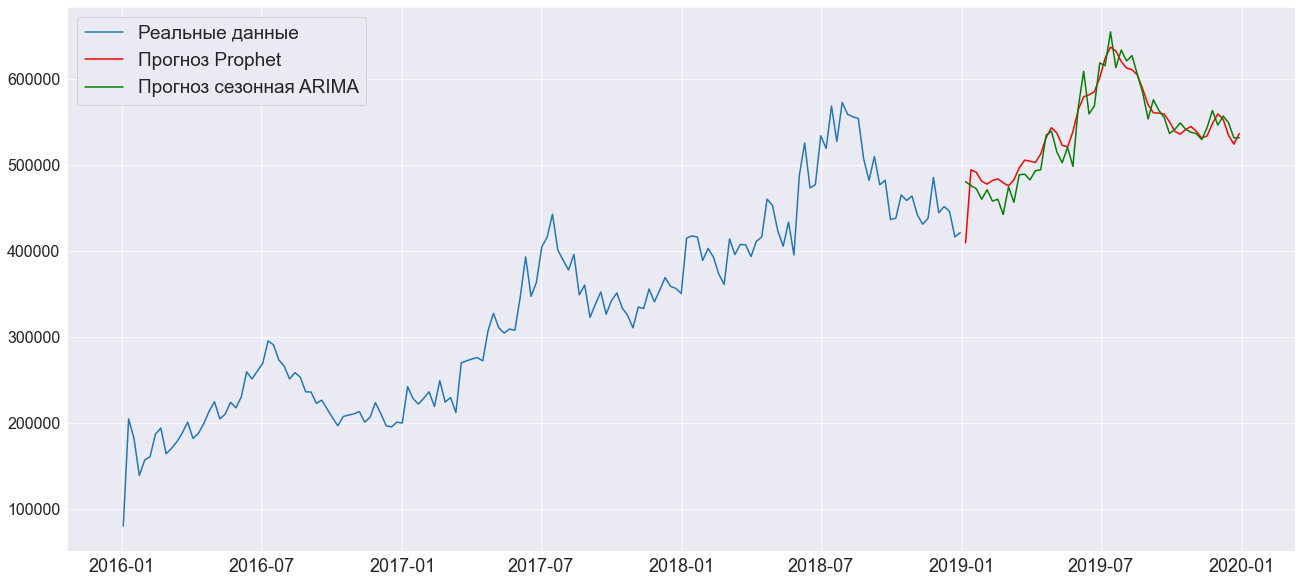

In [20]:
'''se = np.square(for_rmse.s_holt-for_rmse.searches)
mse = np.mean(se)
rmse = np.sqrt(mse)
print('RMSE модели 1 = ',rmse)'''

se = np.square(for_rmse.s_prophet-for_rmse.searches)
mse = np.mean(se)
rmse = np.sqrt(mse)
print('RMSE модели 1 = ',rmse)

se = np.square(for_rmse.s_sarima-for_rmse.searches)
mse = np.mean(se)
rmse = np.sqrt(mse)
print('RMSE модели 2 = ',rmse)

plt.figure(figsize=(22, 10))
plt.plot(w.index, w, label='Реальные данные')
#plt.plot(f_holt_iOS.index, f_holt_iOS, label='Прогноз Holt-Winters', color='k')
plt.plot(f_proph.index, f_proph, label='Прогноз Prophet', color='r')
plt.plot(f_arima.index, f_arima, label='Прогноз сезонная ARIMA', color='g')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

**Прогнозы по остальным каналам также построим с помощью FB.Prophet**

Благодаря высокой корреляции объёмов запросов WEB и других хостов можем смоделировать WEB в 2016 и 2017, чтобы была база для обучения модели

In [21]:
#-------------Моделируем 2016 и 2017 для WEB
dataset_=pd.read_csv('Search_statistics.csv',';',index_col=['date'],parse_dates=['date'],squeeze=True,dayfirst=True)
dataset_['searches'] = dataset_['searches'] * 1.0
dataset_['Year'] = dataset_.index.year
dataset_['Month'] = dataset_.index.month
dataset_['Day'] = dataset_.index.day
dataset_['WeekOfYear'] = dataset_.index.weekofyear 
dataset_['DayOfWeek'] = dataset_.index.dayofweek # 0-6 
dataset_['isWeekend'] = 1*(dataset_['DayOfWeek'] >4)

from datetime import date, datetime
end = "02/08/2018"


dataset=dataset_[(dataset_.Year != 2018)]
del dataset['host']
early = dataset.searches.resample('d').sum()
early=early.to_frame()

dataset=dataset_[(dataset_.Year == 2018) & (dataset_.index<end) ]
del dataset['host']
early_ = dataset.searches.resample('d').sum()
early_=early_.to_frame()

early=pd.concat([early,early_],axis=0)
early_=early.copy()

dataset=dataset_[(dataset_.host == 'web') & (dataset_.Year == 2018) & (dataset_.index>=end)  ]
del dataset['host']
web = dataset.searches.resample('d').sum()
web=web.to_frame()

dataset=dataset_[(dataset_.Year == 2018) & (dataset_.index>=end)  & (dataset_.host != 'web') ]
del dataset['host']
not_web = dataset.searches.resample('d').sum()
not_web=not_web.to_frame()
for i in range(0,6):
    not_web=not_web.drop(not_web.index[0]) 

coef=float(web.sum(axis=0)/not_web.sum(axis=0))
early['s']=early.searches*coef
early.columns=['del','searches']
del early['del']
early

web_full=pd.concat([early,web],axis=0)
#web_full.iloc[770]=web_full.iloc[770]*1.2


'''total_ALLyear_ALLhosts=web_full.searches +pd.concat ([not_web.searches, early_.searches],axis=0)
total_ALLyear_ALLhosts.to_csv('total.csv')
total_ALLyear_ALLhosts.shape
total_ALLyear_ALLhosts=total_ALLyear_ALLhosts.to_frame()
'''
print(colored('---------------------------  Dataframe WEB с моделированными 2016 и 2017  ---------------------------', 'green', attrs=['bold']))
web_full

---------------------------  Dataframe WEB с моделированными 2016 и 2017  ---------------------------


,searches
date,
2016-01-01,27551.748601
2016-01-02,29469.474258
2016-01-03,34710.411040
2016-01-04,35905.073690
2016-01-05,37418.087265
...,...
2018-12-27,111120.000000
2018-12-28,93048.000000
2018-12-29,90239.000000


In [22]:
'''print(colored('---------------------------  Android  ---------------------------', 'green', attrs=['bold']))
dataset=dataset_[dataset_.host=='Android']
del dataset['host']
w_a = dataset.searches.resample('m').sum()
#w_m=w_m.drop(w_m.index[-1]) 
w_a=w_a.to_frame()

andr_decomposition = auto_arima(w_a.searches, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print(andr_decomposition.aic())
#Fit ARIMA(0,1,1)x(1,1,0,52) [intercept=True]; AIC=2210.007, BIC=2220.585, Time=4.528 seconds
#Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=575.288, BIC=577.559, Time=0.020 seconds
mod_a= sm.tsa.statespace.SARIMAX(w_a.searches, exog=None, #без экзогенной переменной SARIMAX становится SARIMA
                                order=(0,1,0),
                                seasonal_order=(0,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

andr_decomposition = mod_a.fit()
pred_uc_a = andr_decomposition.get_forecast(steps=12)
pred_ci_a = pred_uc_a.conf_int()
a_arima=pred_uc_a.predicted_mean.to_frame()
a_arima.columns=['y']
a_arima.index.names = ['ds']
a_arima

plt.figure(figsize=(22, 10))
plt.plot(w_a.index, w_a, label='Реальные данные')
plt.plot(a_arima.index, a_arima, label='Прогноз сезонная ARIMA', color='g')
plt.legend(loc='best', fontsize='xx-large')
plt.yticks(fontsize=16)
plt.show()
print(colored('---------------------------  iOS  ---------------------------', 'green', attrs=['bold']))
dataset=dataset_[dataset_.host=='iOS']
del dataset['host']
w_i = dataset.searches.resample('m').sum()
#w_m=w_m.drop(w_m.index[-1]) 
w_i=w_i.to_frame()

ios_decomposition = auto_arima(w_i.searches, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print(ios_decomposition.aic())
#Fit ARIMA(0,1,1)x(1,1,0,52) [intercept=True]; AIC=2391.869, BIC=2402.447, Time=5.196 seconds
#Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=599.059, BIC=601.330, Time=0.010 seconds
mod_i = sm.tsa.statespace.SARIMAX(w_i.searches, exog=None, #без экзогенной переменной SARIMAX становится SARIMA
                                order=(0,1,0),
                                seasonal_order=(0,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

ios_decomposition = mod_i.fit()
pred_uc_i = ios_decomposition.get_forecast(steps=12)
pred_ci_i = pred_uc_i.conf_int()
i_arima=pred_uc_i.predicted_mean.to_frame()
i_arima.columns=['y']
i_arima.index.names = ['ds']
i_arima

plt.figure(figsize=(22, 10))
plt.plot(w_i.index, w_i, label='Реальные данные')
plt.plot(i_arima.index, i_arima, label='Прогноз сезонная ARIMA', color='g')
plt.legend(loc='best', fontsize='xx-large')
plt.yticks(fontsize=16)
plt.show()
print(colored('---------------------------  web  ---------------------------', 'green', attrs=['bold']))
web_full
w_w = web_full.searches.resample('m').sum()
#w_m=w_m.drop(w_m.index[-1]) 
w_w=w_w.to_frame()

web_decomposition = auto_arima(w_w.searches, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',  suppress_warnings=True, stepwise=True)
print(web_decomposition.aic())
#Fit ARIMA(0,1,1)x(1,1,0,52) [intercept=True]; AIC=2563.649, BIC=2574.226, Time=11.815 seconds
#Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=635.523, BIC=637.794, Time=0.014 seconds
mod_w = sm.tsa.statespace.SARIMAX(w_w.searches, exog=None, #без экзогенной переменной SARIMAX становится SARIMA
                                order=(0,1,0),
                                seasonal_order=(0,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

web_decomposition = mod_w.fit()
pred_uc_w = web_decomposition.get_forecast(steps=12)
pred_ci_w = pred_uc_w.conf_int()
w_arima=pred_uc_w.predicted_mean.to_frame()
w_arima.columns=['y']
w_arima.index.names = ['ds']
w_arima

plt.figure(figsize=(22, 10))
plt.plot(w_w.index, w_w, label='Реальные данные')
plt.plot(w_arima.index, w_arima, label='Прогноз сезонная ARIMA', color='g')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()
print(colored('---------------------------  mobile_web  ---------------------------', 'green', attrs=['bold']))
dataset=dataset_[dataset_.host=='mobile_web']
del dataset['host']
w_m = dataset.searches.resample('m').sum()
#w_m=w_m.drop(w_m.index[-1]) 
w_m=w_m.to_frame()

mweb_decomposition = auto_arima(w_m.searches, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',  suppress_warnings=True, stepwise=True)
print(mweb_decomposition.aic())
#Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=596.442, BIC=598.713, Time=0.010 seconds
mod_mw = sm.tsa.statespace.SARIMAX(w_m.searches, exog=None, #без экзогенной переменной SARIMAX становится SARIMA
                                order=(0,1,0),
                                seasonal_order=(0,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

mweb_decomposition = mod_mw.fit()
pred_uc_m = mweb_decomposition.get_forecast(steps=12)
pred_ci_m = pred_uc_m.conf_int()
m_arima=pred_uc_m.predicted_mean.to_frame()
m_arima.columns=['y']
m_arima.index.names = ['ds']
m_arima

plt.figure(figsize=(22, 10))
plt.plot(w_m.index, w_m, label='Реальные данные')
plt.plot(m_arima.index, m_arima, label='Прогноз сезонная ARIMA', color='g')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()
'''
print("")

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


---------------------------  Android  ---------------------------


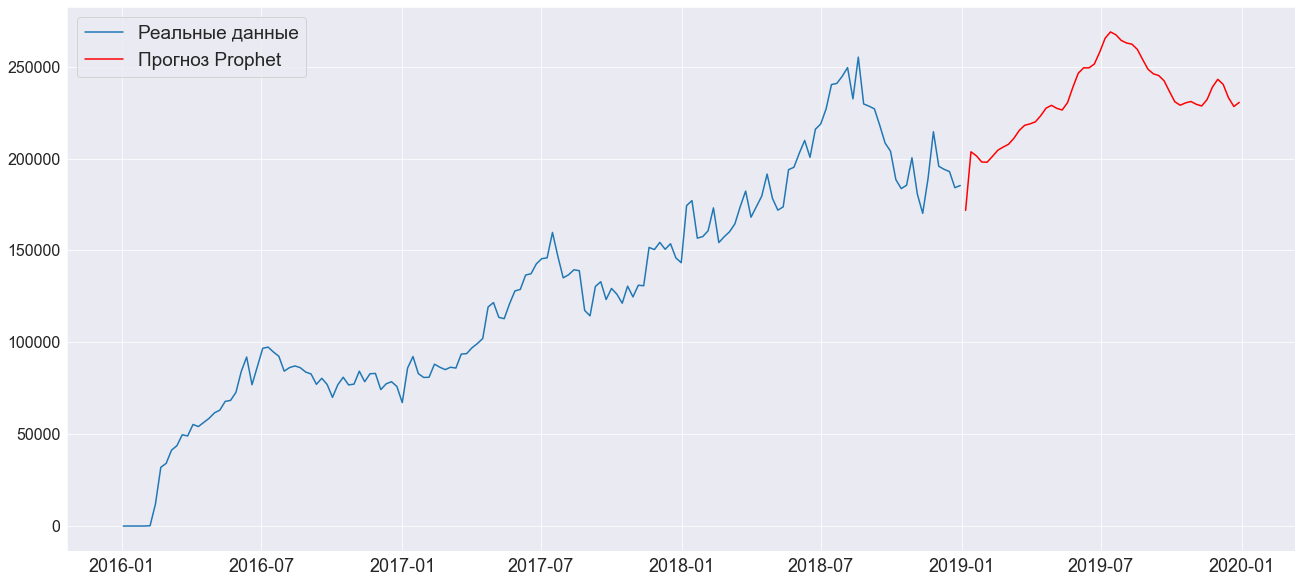

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


---------------------------  mobile_web  ---------------------------


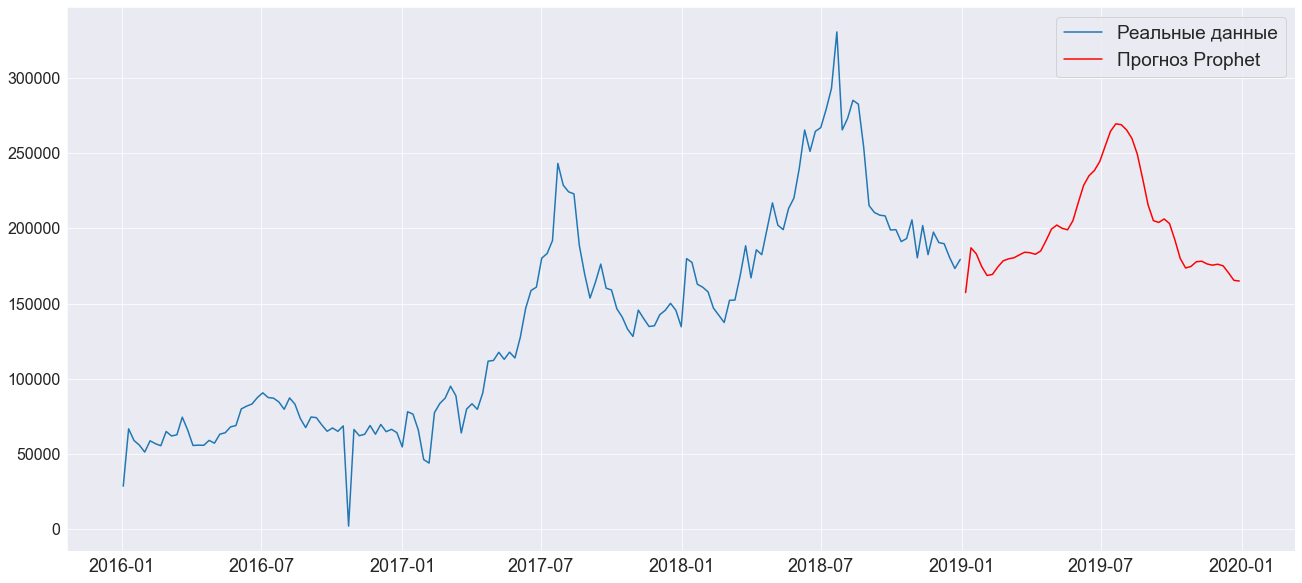

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


---------------------------  web  ---------------------------


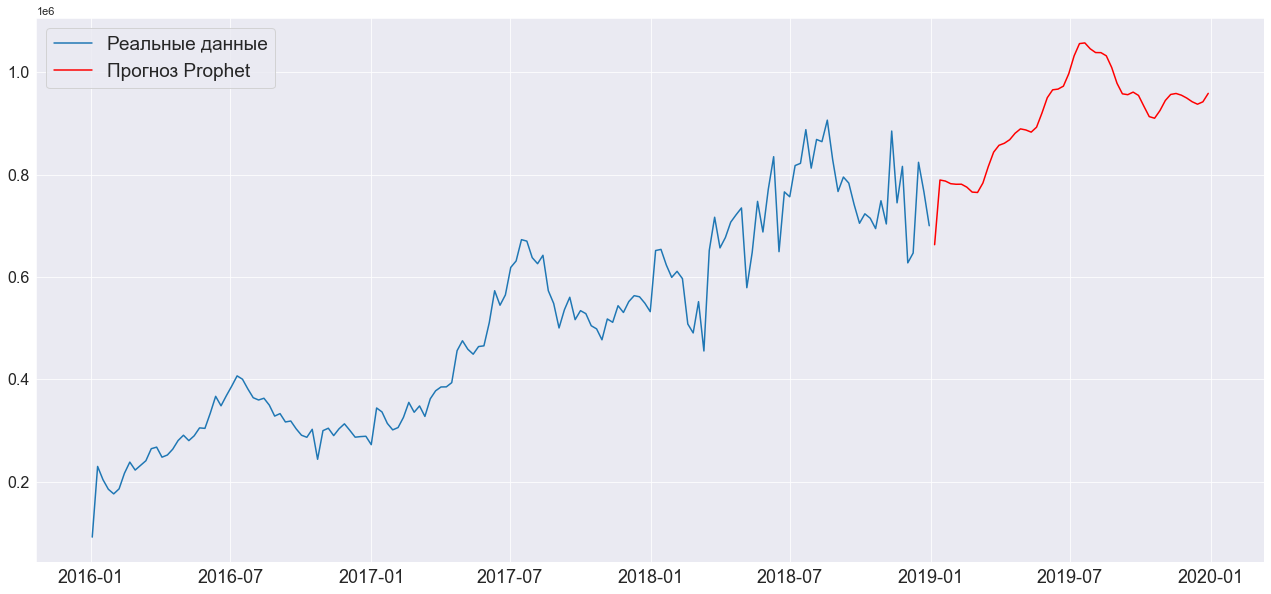

In [23]:
print(colored('---------------------------  Android  ---------------------------', 'green', attrs=['bold']))
from fbprophet import Prophet
ddd=pd.read_csv('Search_statistics.csv',';',index_col=['date'],parse_dates=['date'],squeeze=True,dayfirst=True)
ddd['searches'] = ddd['searches'] * 1.0
dataset=ddd[ddd.host=='Android']
del dataset['host']

dataset.index.names = ['ds']
dataset.columns =['y']
dataset = dataset.reset_index()
m = Prophet()
m.fit(dataset)

future = m.make_future_dataframe(periods=365)
future.tail()

# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

f_proph_train_pred= forecast[['ds', 'yhat']].head(365*3)
f_proph_train_pred.columns=['date','s_prophet']
f_proph_train_pred.index=f_proph_train_pred['date']
del f_proph_train_pred['date']

f_proph_train_pred = f_proph_train_pred.s_prophet.resample('w').sum()
f_proph_train_pred=f_proph_train_pred.to_frame()
f_proph_train_pred

for_rmse=for_rmse.join(f_proph_train_pred, how='inner', lsuffix='_left', rsuffix='_right')

#pd.plotting.register_matplotlib_converters()
f_proph_andr=forecast[['ds','yhat']].tail(365)
f_proph_andr.columns=['ds','y']
f_proph_andr.index=f_proph_andr['ds']
del f_proph_andr['ds']


dataset.index=dataset['ds']
del dataset['ds']

dataset = dataset.y.resample('w').sum()
f_proph_andr_w = f_proph_andr.y.resample('w').sum()
dataset=dataset.drop(dataset.index[-1]) 
f_proph_andr_w=f_proph_andr_w.drop(f_proph_andr_w.index[-1]) 

'''
merged=pd.concat([dataset, f], axis=0)
merged.index=merged.ds
del merged['ds']
w_prophet = merged.y.resample('w').sum()
w_prophet=w_prophet.drop(w_prophet.index[-1]) 
w_prophet.plot()
plt.show()
'''

plt.figure(figsize=(22, 10))
plt.plot(dataset.index, dataset, label='Реальные данные')
plt.plot(f_proph_andr_w.index, f_proph_andr_w, label='Прогноз Prophet', color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

f_proph_andr_w=f_proph_andr_w.to_frame()




print(colored('---------------------------  mobile_web  ---------------------------', 'green', attrs=['bold']))
from fbprophet import Prophet
ddd=pd.read_csv('Search_statistics.csv',';',index_col=['date'],parse_dates=['date'],squeeze=True,dayfirst=True)
ddd['searches'] = ddd['searches'] * 1.0
dataset=ddd[ddd.host=='mobile_web']
del dataset['host']

dataset.index.names = ['ds']
dataset.columns =['y']
dataset = dataset.reset_index()
m = Prophet()
m.fit(dataset)

future = m.make_future_dataframe(periods=365)
future.tail()

# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

f_proph_train_pred= forecast[['ds', 'yhat']].head(365*3)
f_proph_train_pred.columns=['date','s_prophet']
f_proph_train_pred.index=f_proph_train_pred['date']
del f_proph_train_pred['date']

f_proph_train_pred = f_proph_train_pred.s_prophet.resample('w').sum()
f_proph_train_pred=f_proph_train_pred.to_frame()
f_proph_train_pred

for_rmse=for_rmse.join(f_proph_train_pred, how='inner', lsuffix='_left', rsuffix='_right')

#pd.plotting.register_matplotlib_converters()
f_proph_ios=forecast[['ds','yhat']].tail(365)
f_proph_ios.columns=['ds','y']
f_proph_ios.index=f_proph_ios['ds']
del f_proph_ios['ds']

dataset.index=dataset['ds']
del dataset['ds']

dataset = dataset.y.resample('w').sum()
f_proph_ios_w = f_proph_ios.y.resample('w').sum()
dataset=dataset.drop(dataset.index[-1]) 
f_proph_ios_w=f_proph_ios_w.drop(f_proph_ios_w.index[-1]) 

'''
merged=pd.concat([dataset, f], axis=0)
merged.index=merged.ds
del merged['ds']
w_prophet = merged.y.resample('w').sum()
w_prophet=w_prophet.drop(w_prophet.index[-1]) 
w_prophet.plot()
plt.show()
'''

plt.figure(figsize=(22, 10))
plt.plot(dataset.index, dataset, label='Реальные данные')
plt.plot(f_proph_ios_w.index, f_proph_ios_w, label='Прогноз Prophet', color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

f_proph_ios_w=f_proph_ios_w.to_frame()

print(colored('---------------------------  web  ---------------------------', 'green', attrs=['bold']))
dataset=web_full.copy()
dataset.index.names = ['ds']
dataset.columns =['y']
dataset = dataset.reset_index()
m = Prophet()
m.fit(dataset)

future = m.make_future_dataframe(periods=365)
future.tail()

# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

f_proph_train_pred= forecast[['ds', 'yhat']].head(365*3)
f_proph_train_pred.columns=['date','s_prophet']
f_proph_train_pred.index=f_proph_train_pred['date']
del f_proph_train_pred['date']

f_proph_train_pred = f_proph_train_pred.s_prophet.resample('w').sum()
f_proph_train_pred=f_proph_train_pred.to_frame()
f_proph_train_pred

for_rmse=for_rmse.join(f_proph_train_pred, how='inner', lsuffix='_left', rsuffix='_right')

#pd.plotting.register_matplotlib_converters()
f_proph_web=forecast[['ds','yhat']].tail(365)
f_proph_web.columns=['ds','y']
f_proph_web.index=f_proph_web['ds']
del f_proph_web['ds']

dataset.index=dataset['ds']
del dataset['ds']

dataset = dataset.y.resample('w').sum()
f_proph_web_w = f_proph_web.y.resample('w').sum()
dataset=dataset.drop(dataset.index[-1]) 
f_proph_web_w=f_proph_web_w.drop(f_proph_web_w.index[-1]) 

'''
merged=pd.concat([dataset, f], axis=0)
merged.index=merged.ds
del merged['ds']
w_prophet = merged.y.resample('w').sum()
w_prophet=w_prophet.drop(w_prophet.index[-1]) 
w_prophet.plot()
plt.show()
'''

plt.figure(figsize=(22, 10))
plt.plot(dataset.index, dataset, label='Реальные данные')
plt.plot(f_proph_web_w.index, f_proph_web_w, label='Прогноз Prophet', color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

f_proph_web_w=f_proph_web_w.to_frame()





In [24]:
#Второй способ, сложить все хосты, а потом сделать единый прогноз вместо суммы прогнозов по каждому хосту как в варианте1
'''print(colored('---------------------------  total  ---------------------------', 'green', attrs=['bold']))

dataset=total_ALLyear_ALLhosts.copy()
dataset.index.names = ['ds']
dataset.columns =['y']
dataset = dataset.reset_index()
m = Prophet()
m.fit(dataset)

future = m.make_future_dataframe(periods=365)
future.tail()

# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

f_proph_train_pred= forecast[['ds', 'yhat']].head(365*3)
f_proph_train_pred.columns=['date','s_prophet']
f_proph_train_pred.index=f_proph_train_pred['date']
del f_proph_train_pred['date']

f_proph_train_pred = f_proph_train_pred.s_prophet.resample('w').sum()
f_proph_train_pred=f_proph_train_pred.to_frame()
f_proph_train_pred

for_rmse=for_rmse.join(f_proph_train_pred, how='inner', lsuffix='_left', rsuffix='_right')

#pd.plotting.register_matplotlib_converters()
f_proph_all=forecast[['ds','yhat']].tail(365)
f_proph_all.columns=['ds','y']
f_proph_all.index=f_proph_all['ds']
del f_proph_all['ds']

dataset.index=dataset['ds']
del dataset['ds']

dataset = dataset.y.resample('w').sum()
f_proph_all_w = f_proph_all.y.resample('w').sum()
dataset=dataset.drop(dataset.index[-1]) 
f_proph_all_w=f_proph_all_w.drop(f_proph_all_w.index[-1]) 

merged=pd.concat([dataset, f], axis=0)
merged.index=merged.ds
del merged['ds']
w_prophet = merged.y.resample('w').sum()
w_prophet=w_prophet.drop(w_prophet.index[-1]) 
w_prophet.plot()
plt.show()

plt.figure(figsize=(22, 10))
plt.plot(dataset.index, dataset, label='Реальные данные')
plt.plot(f_proph_all_w.index, f_proph_all_w, label='Прогноз Prophet', color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

f_proph_all_w=f_proph_all_w.to_frame()
'''

print("")

**На нашем исходном графике теперь появляется ещё одна линия (прогноз запросов 2019)**

---------------------------  Среднедневное количество запросов в 2019  ---------------------------
270360
------------------------------  Пиковое количество запросов в 2019  ------------------------------
330583
--------------------  Суммарное количество запросов в месяц по всем хостам  --------------------


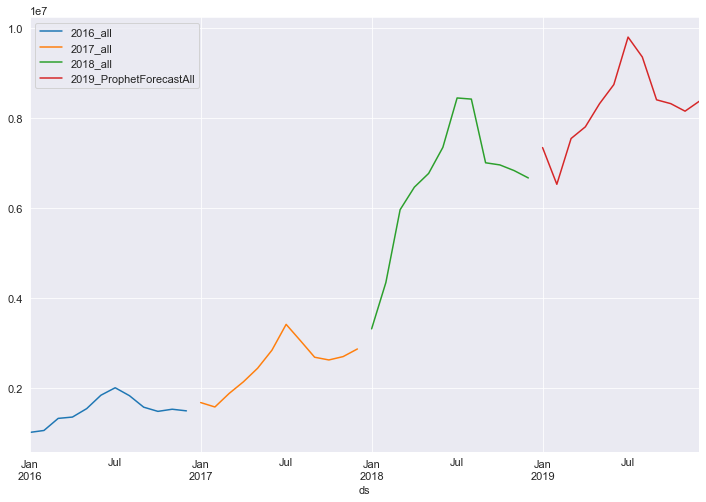

In [25]:
register_matplotlib_converters()

'''a_arima=a_arima.resample('D').interpolate()[::1]/7
i_arima=i_arima.resample('D').interpolate()[::1]/7
w_arima=w_arima.resample('D').interpolate()[::1]/7
f_arima=f_arima.resample('D').interpolate()[::1]/7'''

#total_arima=i_arima+w_arima+a_arima+m_arima
#total_arima = total_arima.y.resample('m').sum()

full2019=f_proph_res_nweb+ f_proph_andr + f_proph_web + f_proph_ios

print(colored('---------------------------  Среднедневное количество запросов в 2019  ---------------------------', 'green', attrs=['bold']))
print(int(full2019.sum(axis=0)/365))
print(colored('------------------------------  Пиковое количество запросов в 2019  ------------------------------', 'green', attrs=['bold']))
print(int(full2019.max(axis=0)))


full2019m = full2019.y.resample('m').sum()
#total_arima_m = total_arima.y.resample('m').sum()

total.head(12).plot()
total.iloc[12:24].plot()
total.tail(12).plot()
full2019m.tail(12).plot()
#total_arima.tail(12).plot(color='red',alpha=0.3)
print(colored('--------------------  Суммарное количество запросов в месяц по всем хостам  --------------------', 'green', attrs=['bold']))
plt.legend(['2016_all','2017_all','2018_all','2019_ProphetForecastAll','2019_SARIMAForecastAll'])
plt.show()


In [26]:

#-------------восстановились на iOS для дальнейших исследований
dataset_=pd.read_csv('Search_statistics.csv',';',index_col=['date'],parse_dates=['date'],squeeze=True,dayfirst=True)
dataset_['searches'] = dataset_['searches'] * 1.0
dataset=dataset_[dataset_.host=='iOS']
del dataset['host']
w = dataset.searches.resample('w').sum()
w=w.drop(w.index[-1]) 



**БОНУСОМ: Модель 4. Нейросеть LSTM**

Решил разобрать процесс прогнозирования с помощью нейросети LSTM. Метод, который занимает далеко не последнее место в прогнозировании временных рядов. Текущие наработки и прогноз по 1 хосту ниже:

Instructions for updating:
Please use Model.fit, which supports generators.


24/24 [==============================] - 0s 7ms/step - loss: 0.1513
rmse:  [3778882.07527589]
Epoch 1/120
3/3 [==============================] - 0s 12ms/step - loss: 0.0566
Epoch 2/120
3/3 [==============================] - 0s 10ms/step - loss: 0.0238
Epoch 3/120
3/3 [==============================] - 0s 11ms/step - loss: 0.0394
Epoch 4/120
3/3 [==============================] - 0s 12ms/step - loss: 0.0605
Epoch 5/120
3/3 [==============================] - 0s 12ms/step - loss: 0.0646
Epoch 6/120
3/3 [==============================] - 0s 11ms/step - loss: 0.0643
Epoch 7/120
3/3 [==============================] - 0s 8ms/step - loss: 0.0604
Epoch 8/120
3/3 [==============================] - 0s 9ms/step - loss: 0.0528
Epoch 9/120
3/3 [==============================] - 0s 8ms/step - loss: 0.0430
Epoch 10/120
3/3 [==============================] - 0s 9ms/step - loss: 0.0349
Epoch 11/120
3/3 [==============================] - 0s 9ms/step - loss: 0.0208
Epoch 12/120
3/3 [======================

rmse:  [3778882.07527589]


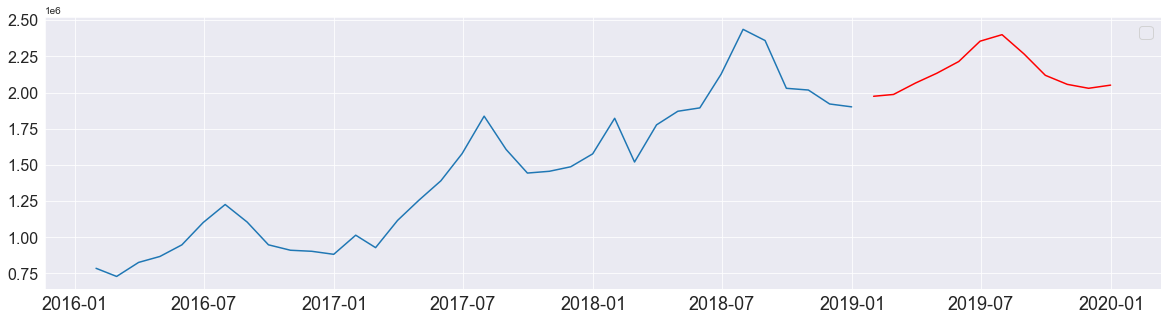

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

dataset_=pd.read_csv('Search_statistics.csv',';',index_col=['date'],parse_dates=['date'],squeeze=True,dayfirst=True)
dataset_['searches'] = dataset_['searches'] * 1.0
dataset=dataset_[dataset_.host=='iOS']
df= dataset.searches.resample('m').sum()
df=pd.to_numeric(df)
df=df.to_frame()
df.index.names = ['Month']
train, test = df[:], df[:]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=1)
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])
df_test = pd.concat([df,df_predict], axis=1)
#----------------
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)
train = df
scaler.fit(train)
train = scaler.transform(train)
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)
model.fit_generator(generator,epochs=120)

pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['searches'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)
plt.show()

**БОНУСОМ: Модель 5. Ручное построение сезонной ARIMA. Не увенчалось успехом** 

Перед началом построения учтём 2 момента:
1.	Как отмечалось в начале наши данные имеют ярко выраженный тренд и ежегодную сезонность (52 недели). Поэтому перед построением модели нам необходимо избавиться от них.
2.	Гетероскедастичность остатков наблюдается, когда ряд идёт вразнос год от года. В этих случаях помогает логарифмирование или преобразование Бокса-Кокса. 

Конструировалось с использованием материалов из:

https://cyberleninka.ru/article/n/metodika-postroeniya-modeli-arima-dlya-prognozirovaniya-dinamiki-vremennyh-ryadov/viewer

https://habr.com/ru/post/210530/

https://habr.com/ru/company/ods/blog/327242/

https://stats.stackexchange.com/questions/474442/pacf-plots-show-unusual-spike-at-high-lag


---------------------------  Посмотрим на диаграммы обычной и частной автокорреляции  ---------------------------



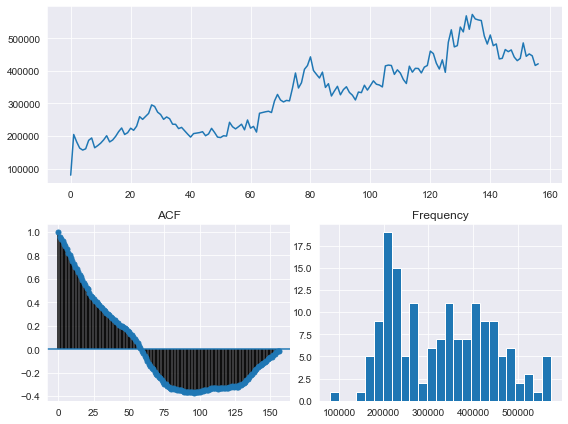

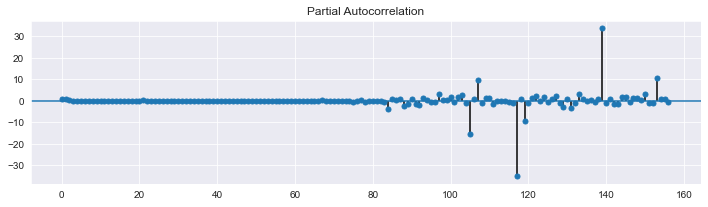

p-value исходного ряда =  0.6151908118946501  => нестационарный ряд

Видим, что исходный ряд не является стационарным, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Попробуем стабилизировать дисперсию преобразованием Бокса-Кокса

По ACF чётко прослеживается сезонность, от которой попробуем избавиться вычитанием такого же ряда со сдвигом на год
По PACF есть частичная корреляция с предыдущими периодами

---------------------------  Применим трансформацию Бокса-Кокса к исходному ряду  ---------------------------

Оптимальный параметр преобразования Бокса-Кокса: 0.484679
p-value ряда после преобразования  =  0.5891038637426668  => нестационарный ряд

Преобразование практически не помогло. Далее, будем пытаться брать первые разности, вычитать временной ряд год к году, чтобы сократить количество значимых лагов в PACF и убрать их проявление на высоких порядках (лаги после 10)


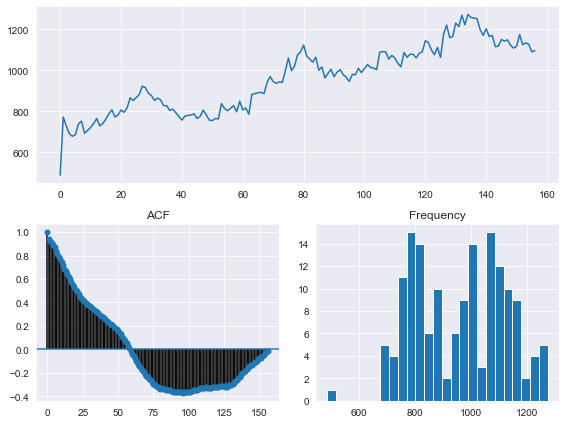

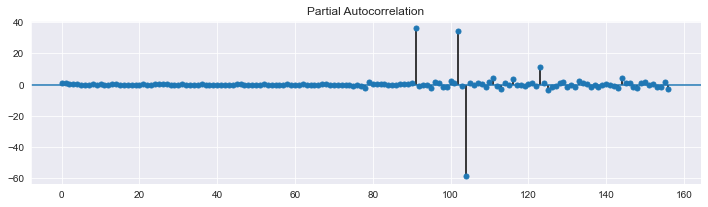


---------------------------  Но прежде попробуем пронормировать ряд по формуле t(n+1)-t(n)/t(n)  ---------------------------



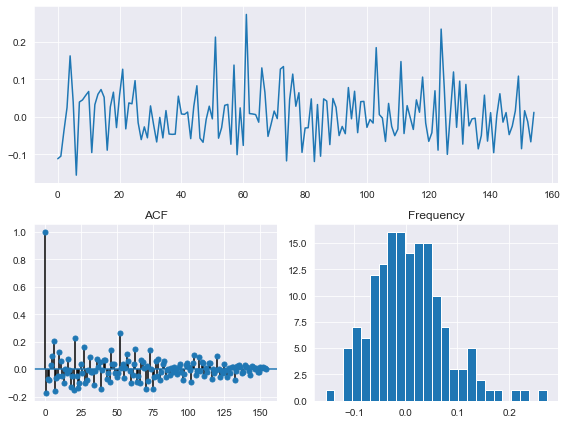


p-value нормированного ряда =  2.0921146924765546e-27  => наконец получаем стационарный ряд
Тест Дики-Фуллера проходим успешно, но по-прежнему беспокоят выбросы PACF на лагах высоких порядков



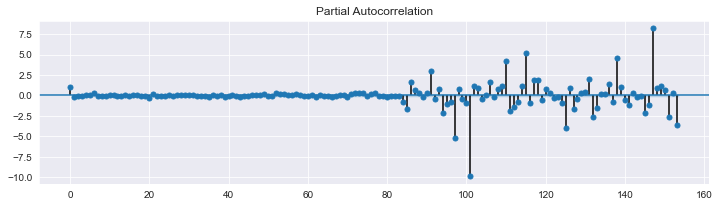


Далее будут делаться попытки получить ряды первых разностей, исключать сезонность, брать первую и вторую разности из такого ряда, но везде останется высокий PACF

Мы знаем, что если значения функции PACF становятся нулевыми, начиная с лага p+1, то модель авторегрессии соответствует свойствам рассматриваемого процесса

Выбросы на старщих лагах сохранятся, поэтому придётся завершить процесс ручного определения параметров p и q для сезонной ARIMA(p,d,q)(P,D,Q). Возможно это обусловлено растущей год от года волатильностью или гетероскедастичностью остатков и отличающимися по виду графиками 2х полугодий 2017 и 2018 (просадка из-за кризиса). В качестве альтернативы в некоторых пособиях рекомендуется использовать ARMA-GARCH

autoARIMA смогла подобрать оптимальный набор параметров, но также показала худший результат среди трёх базовых моделей

PACF первых разностей нормированного ряда


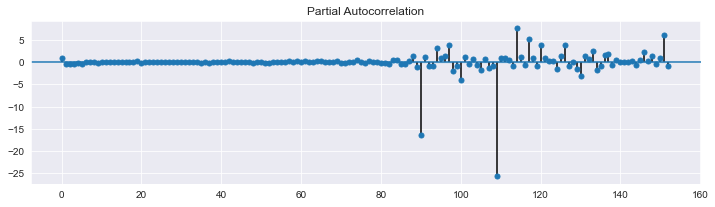

PACF предыдущего ряда за вычетом сезонной компоненты


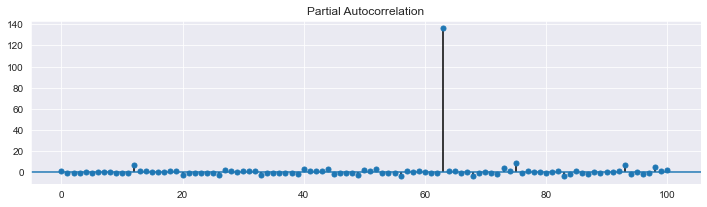

PACF ряда первых сезонных разностей предыдущего ряда


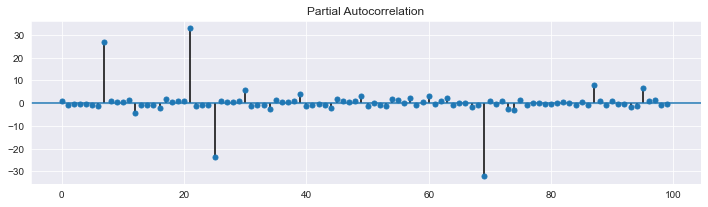

PACF ряда вторых сезонных разностей предыдущего ряда


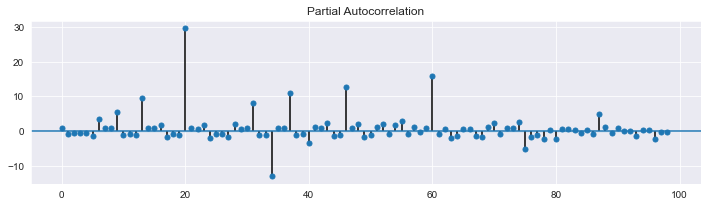

In [28]:
print(chr(13))
print(colored('---------------------------  Посмотрим на диаграммы обычной и частной автокорреляции  ---------------------------', 'green', attrs=['bold']))
print(chr(13))

from statsmodels.graphics.tsaplots import  plot_acf,plot_pacf

tsdisplay(w, lag_max=156)
plt.show()
plt.rc('figure',figsize=(12,3))
plot_pacf(w,lags=156)
plt.show()
print('p-value исходного ряда = ' , adfuller(w,maxlag=52)[1], ' => нестационарный ряд')
print(chr(13))
print('Видим, что исходный ряд не является стационарным, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Попробуем стабилизировать дисперсию преобразованием Бокса-Кокса')
print(chr(13))
print('По ACF чётко прослеживается сезонность, от которой попробуем избавиться вычитанием такого же ряда со сдвигом на год')
print('По PACF есть частичная корреляция с предыдущими периодами')

print(chr(13))
print(colored('---------------------------  Применим трансформацию Бокса-Кокса к исходному ряду  ---------------------------', 'green',attrs=['bold']))
print(chr(13))

#-----------------#преобразование Бокса-Кокса незначительно выровняло дисперсию (2018 смотрелся более динамичным, чем 2016), но сильно не помогло
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

bc = w.copy()
bc=bc.to_frame()

bc['searches'], lmbda = stats.boxcox(bc.searches) # прибавляем единицу, так как в исходном ряде есть нули
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print('p-value ряда после преобразования  = ' , adfuller(bc,maxlag=52)[1], ' => нестационарный ряд')
print(chr(13))
print('Преобразование практически не помогло. Далее, будем пытаться брать первые разности, вычитать временной ряд год к году, чтобы сократить количество значимых лагов в PACF и убрать их проявление на высоких порядках (лаги после 10)')

from pmdarima.utils import tsdisplay
plt.rc('figure',figsize=(12,8))
tsdisplay(bc, lag_max=156)
plt.show()
plt.rc('figure',figsize=(12,3))
plot_pacf(bc,lags=156)
plt.show()

print(chr(13))
print(colored('---------------------------  Но прежде попробуем пронормировать ряд по формуле t(n+1)-t(n)/t(n)  ---------------------------', 'green',attrs=['bold']))
print(chr(13))


#-----------------Нормализация
w=w.to_frame()
norm=(w.searches-w.searches.shift(1))/w.searches.shift(1)
norm=norm.drop(norm.index[0]) 
norm=norm.drop(norm.index[0]) 
norm=norm.to_frame()
tsdisplay(norm, lag_max=154)
plt.show()
plt.rc('figure',figsize=(12,3))
print(chr(13))
print('p-value нормированного ряда = ' , adfuller(norm,maxlag=52)[1],' => наконец получаем стационарный ряд')
print('Тест Дики-Фуллера проходим успешно, но по-прежнему беспокоят выбросы PACF на лагах высоких порядков')
print(chr(13))
plot_pacf(norm,lags=153)
plt.show()

print(chr(13))
print(colored('Далее будут делаться попытки получить ряды первых разностей, исключать сезонность, брать первую и вторую разности из такого ряда, но везде останется высокий PACF',  attrs=['bold']))
print(chr(13))
print(colored('Мы знаем, что если значения функции PACF становятся нулевыми, начиная с лага p+1, то модель авторегрессии соответствует свойствам рассматриваемого процесса',  attrs=['bold']))
print(chr(13))
print(colored('Выбросы на старщих лагах сохранятся, поэтому придётся завершить процесс ручного определения параметров p и q для сезонной ARIMA(p,d,q)(P,D,Q). Возможно это обусловлено растущей год от года волатильностью или гетероскедастичностью остатков и отличающимися по виду графиками 2х полугодий 2017 и 2018 (просадка из-за кризиса). В качестве альтернативы в некоторых пособиях рекомендуется использовать ARMA-GARCH', attrs=['bold']))
print(chr(13))
print(colored('autoARIMA смогла подобрать оптимальный набор параметров, но также показала худший результат среди трёх базовых моделей', attrs=['bold']))
print(chr(13))

print('PACF первых разностей нормированного ряда')
norm_dif1 = norm.diff(periods=1).dropna()
plot_pacf(norm_dif1, lags=152)
plt.show()

print('PACF предыдущего ряда за вычетом сезонной компоненты')
norm_dif1_season = norm_dif1.diff(52).dropna()
plot_pacf(norm_dif1_season, lags=100)
plt.show()

print('PACF ряда первых сезонных разностей предыдущего ряда')
norm_dif1_seasondif1 = norm_dif1_season.diff(periods=1).dropna()
plot_pacf(norm_dif1_seasondif1, lags=99)
plt.show()

print('PACF ряда вторых сезонных разностей предыдущего ряда')
norm_dif1_seasondif2 = norm_dif1_seasondif1.diff(periods=1).dropna()
plot_pacf(norm_dif1_seasondif2, lags=98)
plt.show()